In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from bs4 import BeautifulSoup
import re
import string
import warnings
warnings.filterwarnings('ignore')
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier,ExtraTreesClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score,confusion_matrix

In [3]:
!pip install scikit-learn==1.5.1

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.4/13.4 MB 99.6 MB/s eta 0:00:00
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.3.2
    Uninstalling scikit-learn-1.3.2:
      Successfully uninstalled scikit-learn-1.3.2


In [61]:
import sklearn
print(sklearn.__version__)

1.3.2


In [5]:
d = pd.read_csv('train.csv')
d

,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0
...,...,...,...,...,...,...
404285,404285,433578,379845,How many keywords are there in the Racket prog...,How many keywords are there in PERL Programmin...,0
404286,404286,18840,155606,Do you believe there is life after death?,Is it true that there is life after death?,1
404287,404287,537928,537929,What is one coin?,What's this coin?,0
404288,404288,537930,537931,What is the approx annual cost of living while...,I am having little hairfall problem but I want...,0


In [5]:
d.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 404290 entries, 0 to 404289
Data columns (total 6 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   id            404290 non-null  int64 
 1   qid1          404290 non-null  int64 
 2   qid2          404290 non-null  int64 
 3   question1     404289 non-null  object
 4   question2     404288 non-null  object
 5   is_duplicate  404290 non-null  int64 
dtypes: int64(4), object(2)
memory usage: 18.5+ MB


In [6]:
df = d.sample(50000)

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 50000 entries, 316148 to 84677
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   id            50000 non-null  int64 
 1   qid1          50000 non-null  int64 
 2   qid2          50000 non-null  int64 
 3   question1     50000 non-null  object
 4   question2     50000 non-null  object
 5   is_duplicate  50000 non-null  int64 
dtypes: int64(4), object(2)
memory usage: 2.7+ MB


is_duplicate
0    31601
1    18399
Name: count, dtype: int64
is_duplicate
0    0.63202
1    0.36798
Name: proportion, dtype: float64


<Axes: xlabel='is_duplicate'>

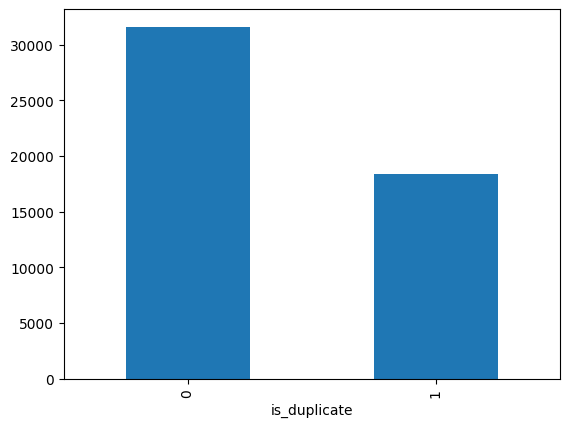

In [29]:
# Distribution of duplicate and non-duplicate questions
print(df['is_duplicate'].value_counts())
print(df['is_duplicate'].value_counts(normalize=True))
df['is_duplicate'].value_counts().plot(kind='bar')

In [40]:
# Repeated questions
qid = pd.Series(list(df['qid1'])+list(df['qid2']))
print('no. of unique questions: ',np.unique(qid).shape[0])
x = qid.value_counts()>1
print('no. of repeated questions: ',x[x].shape[0])

no. of unique questions:  88945
no. of repeated questions:  7384


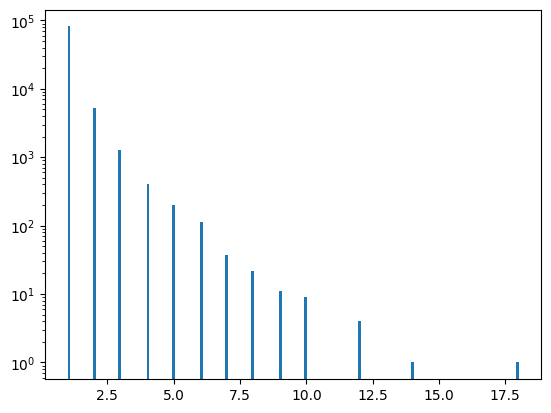

In [45]:
plt.hist(qid.value_counts().values,bins=160)
plt.yscale('log')
plt.show()

In [5]:
ques_df = df[['question1','question2']]
ques_df.head()

,question1,question2
398782,What is the best marketing automation tool for...,What is the best marketing automation tool for...
115086,I am poor but I want to invest. What should I do?,I am quite poor and I want to be very rich. Wh...
327711,I am from India and live abroad. I met a guy f...,T.I.E.T to Thapar University to Thapar Univers...
367788,Why do so many people in the U.S. hate the sou...,My boyfriend doesnt feel guilty when he hurts ...
151235,Consequences of Bhopal gas tragedy?,What was the reason behind the Bhopal gas trag...


BAG OF WORDS

In [7]:
cv = CountVectorizer(max_features=3000)
questions = list(ques_df['question1'])+list(ques_df['question2'])
q1_arr,q2_arr = np.vsplit(cv.fit_transform(questions).toarray(),2)

In [38]:
q1_arr

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [7]:
temp1 = pd.DataFrame(q1_arr,index=ques_df.index)
temp2 = pd.DataFrame(q2_arr,index=ques_df.index)
temp_df = pd.concat([temp1,temp2],axis=1)

In [8]:
temp_df.shape

(50000, 6000)

In [9]:
temp_df['is_duplicate'] = df['is_duplicate']

In [10]:
temp_df.head()

,0,1,2,3,4,5,6,7,8,9,...,2991,2992,2993,2994,2995,2996,2997,2998,2999,is_duplicate
398782,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
115086,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
327711,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
367788,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
151235,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [14]:
X_train,X_test,y_train,y_test = train_test_split(temp_df.iloc[:,0:-1].values,temp_df.iloc[:,-1].values,test_size=0.3,random_state=42)

Model Building

In [23]:
rf = RandomForestClassifier()
rf.fit(X_train,y_train)

y_pred = rf.predict(X_test)
print(accuracy_score(y_test,y_pred))
print(confusion_matrix(y_test,y_pred))

0.7502
[[8706  760]
 [2987 2547]]


In [21]:
ets = ExtraTreesClassifier()
ets.fit(X_train,y_train)

y_pred = ets.predict(X_test)
print(accuracy_score(y_test,y_pred))
print(confusion_matrix(y_test,y_pred))

0.7569333333333333
[[8598  868]
 [2778 2756]]


In [25]:
xgb = XGBClassifier()
xgb.fit(X_train,y_train)

y_pred = xgb.predict(X_test)
print(accuracy_score(y_test,y_pred))
print(confusion_matrix(y_test,y_pred))

0.7349333333333333
[[8616  850]
 [3126 2408]]


TF-IDF

In [7]:
tfid = TfidfVectorizer(max_features=3000)
q1_arrt,q2_arrt = np.vsplit(tfid.fit_transform(questions).toarray(),2)

In [8]:
temp1 = pd.DataFrame(q1_arrt,index=ques_df.index)
temp2 = pd.DataFrame(q2_arrt,index=ques_df.index)
temp_dft = pd.concat([temp1,temp2],axis=1)
temp_dft['is_duplicate'] = df['is_duplicate']
temp_dft.shape

(50000, 6001)

In [9]:
X_train,X_test,y_train,y_test = train_test_split(temp_dft.iloc[:,0:-1].values,temp_dft.iloc[:,-1].values,test_size=0.3,random_state=42)

In [11]:
#rf = RandomForestClassifier()
#rf.fit(X_train,y_train)

y_pred = rf.predict(X_test)
print(accuracy_score(y_test,y_pred))
print(confusion_matrix(y_test,y_pred))

0.7497333333333334
[[8781  685]
 [3069 2465]]


Adding new features (Feature Engineering) :
q1length,q2length,q1words,q2words,commonwords,totalwords,sharedwords





In [8]:
#question length
df['q1_len'] = df['question1'].str.len()
df['q2_len'] = df['question2'].str.len()

In [9]:
#question words
df['q1_num_words'] = df['question1'].apply(lambda row: len(row.split(' ')))
df['q2_num_words'] = df['question2'].apply(lambda row: len(row.split(' ')))

In [10]:
#commonwords
def common_words(row):
  w1=set(map(lambda w: w.lower().strip(), row['question1'].split(' ')))
  w2=set(map(lambda w: w.lower().strip(), row['question2'].split(' ')))
  return len(w1 & w2)

df['common_words'] = df.apply(common_words, axis=1)

In [11]:
#totalwords
def total_words(row):
  w1=set(map(lambda w: w.lower().strip(), row['question1'].split(' ')))
  w2=set(map(lambda w: w.lower().strip(), row['question2'].split(' ')))
  return (len(w1)+len(w2))

df['total_words'] = df.apply(total_words, axis=1)

In [12]:
#sharedwords
df['word_share'] = round(df['common_words']/df['total_words'],2)

In [22]:
df.head(2)

,id,qid1,qid2,question1,question2,is_duplicate,q1_len,q2_len,q1_num_words,q2_num_words,common_words,total_words,word_share
185969,185969,283785,283786,How can someone apply for off campus placement...,"Do companies like Microsoft, Amazon, Deloitte,...",0,141,105,22,15,6,37,0.16
136852,136852,218253,6080,What happens to the Indian students trying to ...,Should I (a prospective Indian student) stop a...,1,108,129,20,21,9,38,0.24


EDA

maximum characters in question1:  391
minimum characters in question1:  1
average characters in question1:  59


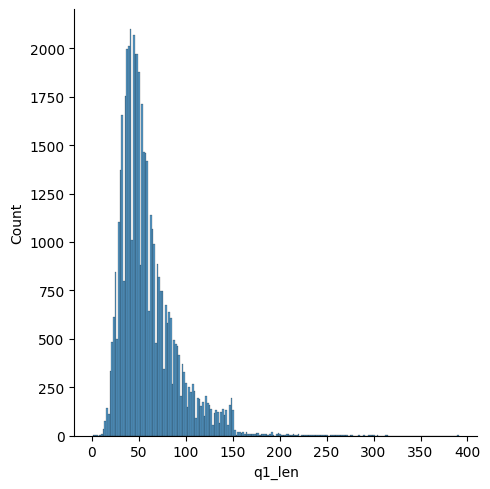

In [29]:
#min max of questions length
sns.displot(df['q1_len'])
print('maximum characters in question1: ' ,df['q1_len'].max())
print('minimum characters in question1: ' ,df['q1_len'].min())
print('average characters in question1: ' ,int(df['q1_len'].mean()))

maximum characters in question1:  1151
minimum characters in question1:  6
average characters in question1:  60


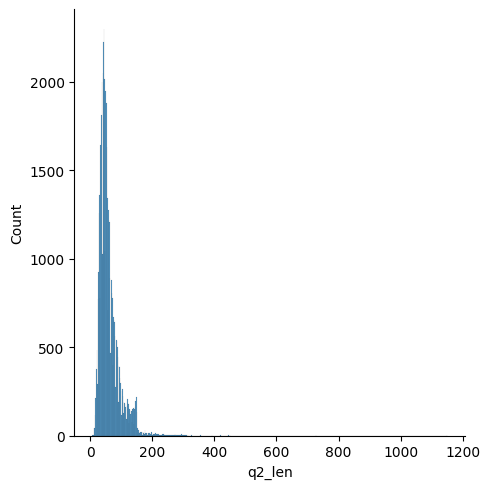

In [28]:
sns.displot(df['q2_len'])
print('maximum characters in question1: ' ,df['q2_len'].max())
print('minimum characters in question1: ' ,df['q2_len'].min())
print('average characters in question1: ' ,int(df['q2_len'].mean()))

maximum characters in question1:  72
minimum characters in question1:  1
average characters in question1:  10


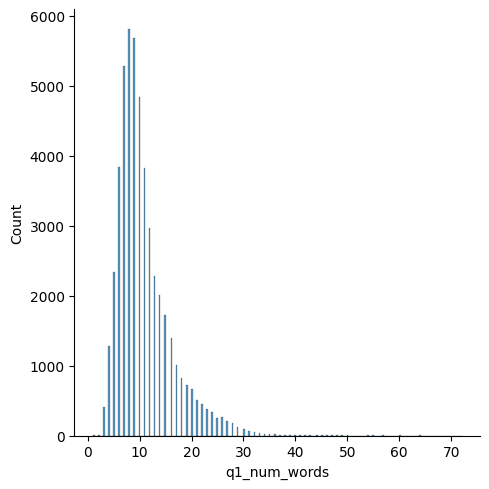

In [30]:
#min max of no. questions words
sns.displot(df['q1_num_words'])
print('maximum characters in question1: ' ,df['q1_num_words'].max())
print('minimum characters in question1: ' ,df['q1_num_words'].min())
print('average characters in question1: ' ,int(df['q1_num_words'].mean()))

maximum characters in question1:  237
minimum characters in question1:  1
average characters in question1:  11


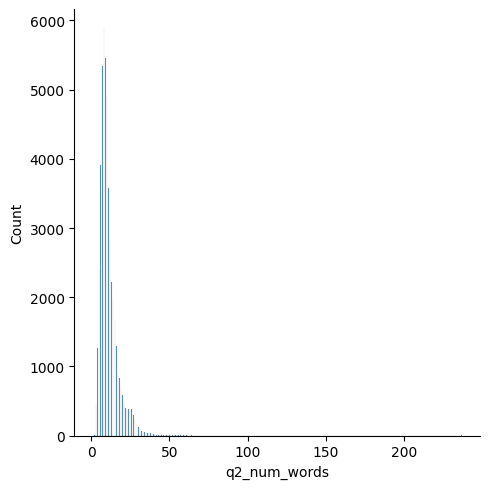

In [31]:
sns.displot(df['q2_num_words'])
print('maximum characters in question1: ' ,df['q2_num_words'].max())
print('minimum characters in question1: ' ,df['q2_num_words'].min())
print('average characters in question1: ' ,int(df['q2_num_words'].mean()))

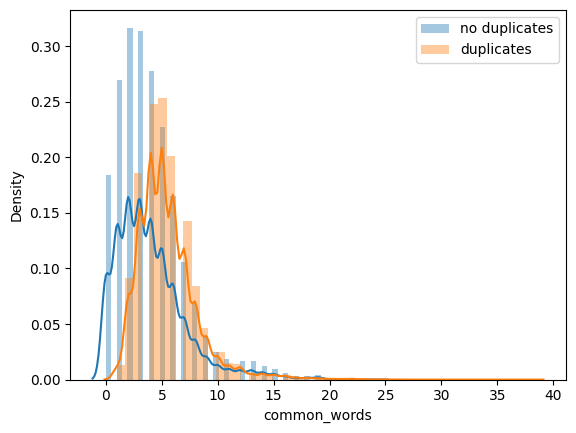

In [33]:
#common words distribution
sns.distplot(df[df['is_duplicate']==0]['common_words'],label='no duplicates')
sns.distplot(df[df['is_duplicate']==1]['common_words'],label='duplicates')
plt.legend()
plt.show()

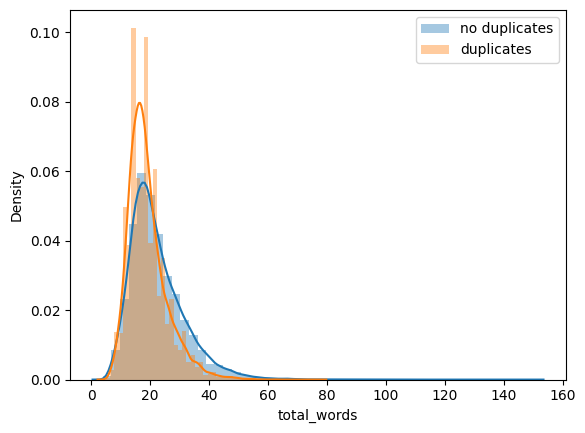

In [34]:
#total words distribution
sns.distplot(df[df['is_duplicate']==0]['total_words'],label='no duplicates')
sns.distplot(df[df['is_duplicate']==1]['total_words'],label='duplicates')
plt.legend()
plt.show()

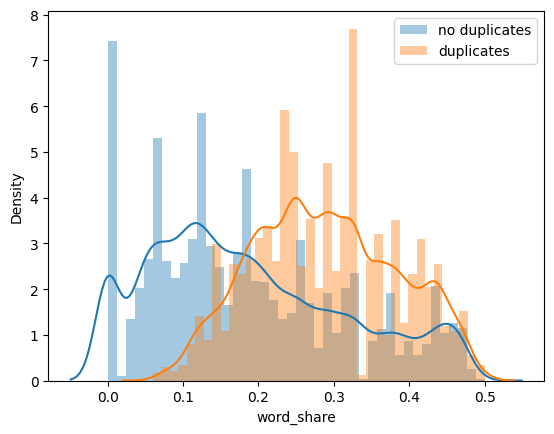

In [35]:
#shared words distribution
sns.distplot(df[df['is_duplicate']==0]['word_share'],label='no duplicates')
sns.distplot(df[df['is_duplicate']==1]['word_share'],label='duplicates')
plt.legend()
plt.show()

In [17]:
ques_df = df[['question1','question2']]
questions = list(ques_df['question1']) + list(ques_df['question2'])
q1_arr, q2_arr = np.vsplit(cv.fit_transform(questions).toarray(),2)

In [18]:
temp1 = pd.DataFrame(q1_arr,index=ques_df.index)
temp2 = pd.DataFrame(q2_arr,index=ques_df.index)
temp_df = pd.concat([temp1,temp2],axis=1)
temp_df['is_duplicate'] = df['is_duplicate']
temp_df.head(2)

,0,1,2,3,4,5,6,7,8,9,...,2991,2992,2993,2994,2995,2996,2997,2998,2999,is_duplicate
398782,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
115086,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [30]:
final_df = df.drop(columns=['id','qid1','qid2','question1','question2','is_duplicate'])
final_df = pd.concat([final_df,temp_df],axis=1)

In [31]:
final_df.head()

,q1_len,q2_len,q1_num_words,q2_num_words,common_words,total_words,word_share,0,1,2,...,2991,2992,2993,2994,2995,2996,2997,2998,2999,is_duplicate
398782,76,77,12,12,11,24,0.46,0,0,0,...,0,0,0,0,0,0,0,0,0,1
115086,49,57,12,15,7,23,0.30,0,0,0,...,0,0,0,0,0,0,0,0,0,0
327711,105,120,25,17,2,34,0.06,0,0,0,...,0,0,0,0,0,0,0,0,0,0
367788,59,146,12,30,0,32,0.00,0,0,0,...,0,1,0,0,0,0,0,0,0,0
151235,35,50,5,9,3,13,0.23,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [32]:
X_train,X_test,y_train,y_test = train_test_split(final_df.iloc[:,0:-1].values,final_df.iloc[:,-1].values,test_size=0.3,random_state=42)

RF-MODEL BUILDING (+BASIC FEATURES)

In [35]:
rf_b = RandomForestClassifier()
rf_b.fit(X_train,y_train)

y_pred = rf_b.predict(X_test)
print(accuracy_score(y_test,y_pred))
print(confusion_matrix(y_test,y_pred))

0.7765333333333333
[[8362 1104]
 [2248 3286]]


Preprocessing + Advance Features

In [14]:
!pip install fuzzywuzzy
!pip install distance
import distance
from fuzzywuzzy import fuzz

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 180.3/180.3 kB 11.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for distance: filename=Distance-0.1.3-py3-none-any.whl size=16257 sha256=4b48cee126a96ea626bd1017b64e9d77c9bb5da8af4ccf8fcc8a6a39597b303d
  Stored in directory: /root/.cache/pip/wheels/e8/bb/de/f71bf63559ea9a921059a5405806f7ff6ed612a9231c4a9309
Successfully built distance


In [15]:
nltk.download('punkt')
nltk.download('stopwords')
ps = PorterStemmer()

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [26]:
df.head()

,id,qid1,qid2,question1,question2,is_duplicate,q1_len,q2_len,q1_num_words,q2_num_words,common_words,total_words,word_share
185969,185969,283785,283786,How can someone apply for off campus placement...,"Do companies like Microsoft, Amazon, Deloitte,...",0,141,105,22,15,6,37,0.16
136852,136852,218253,6080,What happens to the Indian students trying to ...,Should I (a prospective Indian student) stop a...,1,108,129,20,21,9,38,0.24
363460,363460,137313,493444,What is your internet speed?,What is internet speed in IIM's?,0,28,32,5,6,3,11,0.27
233555,233555,343835,343836,Where in india can I get first aid and CPR tra...,How beneficial is it to have a first aid app r...,0,52,87,11,16,2,25,0.08
246594,246594,359665,359666,How long should I stay at my first company?,How long should I stay at my first job?,1,43,39,9,9,8,18,0.44


In [27]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 50000 entries, 185969 to 34879
Data columns (total 13 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   id            50000 non-null  int64  
 1   qid1          50000 non-null  int64  
 2   qid2          50000 non-null  int64  
 3   question1     50000 non-null  object 
 4   question2     50000 non-null  object 
 5   is_duplicate  50000 non-null  int64  
 6   q1_len        50000 non-null  int64  
 7   q2_len        50000 non-null  int64  
 8   q1_num_words  50000 non-null  int64  
 9   q2_num_words  50000 non-null  int64  
 10  common_words  50000 non-null  int64  
 11  total_words   50000 non-null  int64  
 12  word_share    50000 non-null  float64
dtypes: float64(1), int64(10), object(2)
memory usage: 5.3+ MB


In [22]:
def preprocessor(q):
  q = str(q).lower().strip()

  #replacing special characters and unusual patterns:
  useless_character = {'%':'percent','$':'dollar','@':'at','₹':'rupee','€':'euro','[math]':''}

  for old,new in useless_character.items():
    q = q.replace(old,new)

  #Replacing some numbers with string equivalents
  q = q.replace(',000,000,000','b')
  q = q.replace(',000,000','m')
  q = q.replace(',000','k')
  q = re.sub(r'([0-9]+)000000000', r'\1b', q)
  q = re.sub(r'([0-9]+)000000', r'\1m', q)
  q = re.sub(r'([0-9]+)000', r'\1k', q)

  #Decontracting words
  contractions = {
    "ain't": "am not",
    "aren't": "are not",
    "can't": "can not",
    "can't've": "can not have",
    "'cause": "because",
    "could've": "could have",
    "couldn't": "could not",
    "couldn't've": "could not have",
    "didn't": "did not",
    "doesn't": "does not",
    "don't": "do not",
    "hadn't": "had not",
    "hadn't've": "had not have",
    "hasn't": "has not",
    "haven't": "have not",
    "he'd": "he would",
    "he'd've": "he would have",
    "he'll": "he will",
    "he'll've": "he will have",
    "he's": "he is",
    "how'd": "how did",
    "how'd'y": "how do you",
    "how'll": "how will",
    "how's": "how is",
    "i'd": "i would",
    "i'd've": "i would have",
    "i'll": "i will",
    "i'll've": "i will have",
    "i'm": "i am",
    "i've": "i have",
    "isn't": "is not",
    "it'd": "it would",
    "it'd've": "it would have",
    "it'll": "it will",
    "it'll've": "it will have",
    "it's": "it is",
    "let's": "let us",
    "ma'am": "madam",
    "mayn't": "may not",
    "might've": "might have",
    "mightn't": "might not",
    "mightn't've": "might not have",
    "must've": "must have",
    "mustn't": "must not",
    "mustn't've": "must not have",
    "needn't": "need not",
    "needn't've": "need not have",
    "o'clock": "of the clock",
    "oughtn't": "ought not",
    "oughtn't've": "ought not have",
    "shan't": "shall not",
    "sha'n't": "shall not",
    "shan't've": "shall not have",
    "she'd": "she would",
    "she'd've": "she would have",
    "she'll": "she will",
    "she'll've": "she will have",
    "she's": "she is",
    "should've": "should have",
    "shouldn't": "should not",
    "shouldn't've": "should not have",
    "so've": "so have",
    "so's": "so as",
    "that'd": "that would",
    "that'd've": "that would have",
    "that's": "that is",
    "there'd": "there would",
    "there'd've": "there would have",
    "there's": "there is",
    "they'd": "they would",
    "they'd've": "they would have",
    "they'll": "they will",
    "they'll've": "they will have",
    "they're": "they are",
    "they've": "they have",
    "to've": "to have",
    "wasn't": "was not",
    "we'd": "we would",
    "we'd've": "we would have",
    "we'll": "we will",
    "we'll've": "we will have",
    "we're": "we are",
    "we've": "we have",
    "weren't": "were not",
    "what'll": "what will",
    "what'll've": "what will have",
    "what're": "what are",
    "what's": "what is",
    "what've": "what have",
    "when's": "when is",
    "when've": "when have",
    "where'd": "where did",
    "where's": "where is",
    "where've": "where have",
    "who'll": "who will",
    "who'll've": "who will have",
    "who's": "who is",
    "who've": "who have",
    "why's": "why is",
    "why've": "why have",
    "will've": "will have",
    "won't": "will not",
    "won't've": "will not have",
    "would've": "would have",
    "wouldn't": "would not",
    "wouldn't've": "would not have",
    "y'all": "you all",
    "y'all'd": "you all would",
    "y'all'd've": "you all would have",
    "y'all're": "you all are",
    "y'all've": "you all have",
    "you'd": "you would",
    "you'd've": "you would have",
    "you'll": "you will",
    "you'll've": "you will have",
    "you're": "you are",
    "you've": "you have"
  }

  decontracted =[]

  for word in q.split():
    if word in contractions:
      word = contractions[word]
    decontracted.append(word)
  q = ' '.join(decontracted)
  q = q.replace("'ve", " have")
  q = q.replace("n't", " not")
  q = q.replace("'re", " are")
  q = q.replace("'ll", " will")

  #removing HTML tags
  q = BeautifulSoup(q)
  q = q.get_text()

  #removing punctuations and applying stemming
  q = word_tokenize(q)
  stemmed_word = []
  for word in q:
      if word not in string.punctuation:  #word not in stop_words and :-for later use
          stemmed_word.append(ps.stem(word))
      q = ' '.join(stemmed_word)

  return q

In [24]:
type(preprocessor("I've already! wasn't <b>done</b>?"))

str

In [25]:
df['question1'] = df['question1'].apply(preprocessor)
df['question2'] = df['question2'].apply(preprocessor)

In [26]:
df.head()

,id,qid1,qid2,question1,question2,is_duplicate,q1_len,q2_len,q1_num_words,q2_num_words,common_words,total_words,word_share
316148,316148,441138,441139,are some peopl natur mean spirit,are some peopl natur mean,1,40,31,6,5,4,11,0.36
44799,44799,80366,80367,how is angular momentum conserv,is angular momentum conserv dure elast collis,0,34,55,5,7,3,12,0.25
315320,315320,46241,160824,how can one live a simpl and fulfil life,what is the best way to live good and simpl life,1,46,51,9,11,4,20,0.20
142973,142973,1206,226626,whi doe saturn benefit a hou it sit in slowli,whi should not you use drano in a dishwash if ...,0,50,68,10,12,4,22,0.18
23804,23804,6466,44556,what are the salari of ia ip and if offic,are class requir to becom an ia or ip offic,0,51,53,10,10,2,20,0.10


TOKEN FEATURES

In [27]:
# token features :
def fetch_token_features(row):

  q1 = row['question1']
  q2 = row['question2']

  SAFE_DIV =0.0001
  STOP_WORDS = stopwords.words('english')
  token_features = [0.0]*8

  #converting the sentences in tokens:
  q1_token = word_tokenize(q1)
  q2_token = word_tokenize(q2)

  if len(q1_token) == 0 or len(q2_token) == 0:
    return token_features

  #fetching non-stopwords from questions
  q1_words = set([word for word in q1_token if word not in STOP_WORDS])
  q2_words = set([word for word in q2_token if word not in STOP_WORDS])

  #fetching stopwords from questions
  q1_stop = set([word for word in q1_token if word in STOP_WORDS])
  q2_stop = set([word for word in q2_token if word in STOP_WORDS])

  #common non-stop words:
  common_word_count = len(q1_words.intersection(q2_words))

  #common stop words:
  common_stop_count = len(q1_stop.intersection(q2_stop))

  #Get the common Tokens
  common_token_count = len(set(q1_token).intersection(set(q2_token)))

  token_features[0] = common_word_count/(min(len(q1_words),len(q2_words))+SAFE_DIV)
  token_features[1] = common_word_count/(max(len(q1_words),len(q2_words))+SAFE_DIV)
  token_features[2] = common_stop_count/(min(len(q1_stop),len(q2_stop))+SAFE_DIV)
  token_features[3] = common_stop_count/(max(len(q1_stop),len(q2_stop))+SAFE_DIV)
  token_features[4] = common_token_count/(min(len(q1_token),len(q2_token))+SAFE_DIV)
  token_features[5] = common_token_count/(max(len(q1_token),len(q2_token))+SAFE_DIV)

  # Last & First word same or not:
  token_features[6] = int(q1_token[-1] == q2_token[-1])
  token_features[7] = int(q1_token[0] == q2_token[0])

  return token_features

In [28]:
token_features = df.apply(fetch_token_features,axis=1)
df['cwc_min'] = list(map(lambda x: x[0], token_features))
df['cwc_max'] = list(map(lambda x: x[1], token_features))
df['csc_min'] = list(map(lambda x: x[2], token_features))
df['csc_max'] = list(map(lambda x: x[3], token_features))
df['ctc_min'] = list(map(lambda x: x[4], token_features))
df['ctc_max'] = list(map(lambda x: x[5], token_features))
df['first_word_eq'] = list(map(lambda x: x[6], token_features))
df['last_word_eq'] = list(map(lambda x: x[7], token_features))


In [29]:
df.head(2)

,id,qid1,qid2,question1,question2,is_duplicate,q1_len,q2_len,q1_num_words,q2_num_words,...,total_words,word_share,cwc_min,cwc_max,csc_min,csc_max,ctc_min,ctc_max,first_word_eq,last_word_eq
316148,316148,441138,441139,are some peopl natur mean spirit,are some peopl natur mean,1,40,31,6,5,...,11,0.36,0.999967,0.749981,0.99995,0.999950,0.999980,0.833319,0,1
44799,44799,80366,80367,how is angular momentum conserv,is angular momentum conserv dure elast collis,0,34,55,5,7,...,12,0.25,0.999967,0.499992,0.99990,0.499975,0.799984,0.571420,0,0


In [32]:
def fetch_length_features(row):

    q1 = row['question1']
    q2 = row['question2']

    length_features = [0.0]*3

    # Converting the Sentence into Tokens:
    q1_tokens = word_tokenize(q1)
    q2_tokens = word_tokenize(q2)

    if len(q1_tokens) == 0 or len(q2_tokens) == 0:
        return length_features

    # Absolute length features
    length_features[0] = abs(len(q1_tokens) - len(q2_tokens))

    #Average Token Length of both Questions
    length_features[1] = (len(q1_tokens) + len(q2_tokens))/2

    strs = list(distance.lcsubstrings(q1, q2))
     # Check if there's at least one common substring
    if len(strs) > 0:
       length_features[2] = len(strs[0]) / (min(len(q1), len(q2)) + 1)
    else:
     # Handle the case where no common substring is found
       length_features[2] = 0.0

    return length_features

In [33]:
length_features = df.apply(fetch_length_features, axis=1)

df['abs_len_diff'] = list(map(lambda x: x[0], length_features))
df['mean_len'] = list(map(lambda x: x[1], length_features))
df['longest_substr_ratio'] = list(map(lambda x: x[2], length_features))

In [34]:
def fetch_fuzzy_features(row):
    q1 = row['question1']
    q2 = row['question2']

    fuzzy_features = [0.0]*4

    # fuzz_ratio
    fuzzy_features[0] = fuzz.QRatio(q1, q2)

    # fuzz_partial_ratio
    fuzzy_features[1] = fuzz.partial_ratio(q1, q2)

    # token_sort_ratio
    fuzzy_features[2] = fuzz.token_sort_ratio(q1, q2)

    # token_set_ratio
    fuzzy_features[3] = fuzz.token_set_ratio(q1, q2)

    return fuzzy_features

In [35]:
fuzzy_features = df.apply(fetch_fuzzy_features, axis=1)
df['fuzz_ratio'] = list(map(lambda x: x[0], fuzzy_features))
df['fuzz_partial_ratio'] = list(map(lambda x: x[1], fuzzy_features))
df['token_sort_ratio'] = list(map(lambda x: x[2], fuzzy_features))
df['token_set_ratio'] = list(map(lambda x: x[3], fuzzy_features))

In [36]:
df.head()

,id,qid1,qid2,question1,question2,is_duplicate,q1_len,q2_len,q1_num_words,q2_num_words,...,ctc_max,first_word_eq,last_word_eq,abs_len_diff,mean_len,longest_substr_ratio,fuzz_ratio,fuzz_partial_ratio,token_sort_ratio,token_set_ratio
316148,316148,441138,441139,are some peopl natur mean spirit,are some peopl natur mean,1,40,31,6,5,...,0.833319,0,1,1,5.5,0.961538,88,100,88,100
44799,44799,80366,80367,how is angular momentum conserv,is angular momentum conserv dure elast collis,0,34,55,5,7,...,0.571420,0,0,2,6.0,0.843750,71,87,74,93
315320,315320,46241,160824,how can one live a simpl and fulfil life,what is the best way to live good and simpl life,1,46,51,9,11,...,0.363633,1,0,2,10.0,0.170732,45,57,50,64
142973,142973,1206,226626,whi doe saturn benefit a hou it sit in slowli,whi should not you use drano in a dishwash if ...,0,50,68,10,12,...,0.357140,1,1,4,12.0,0.195652,57,53,50,57
23804,23804,6466,44556,what are the salari of ia ip and if offic,are class requir to becom an ia or ip offic,0,51,53,10,10,...,0.399996,1,0,0,10.0,0.142857,52,49,55,62


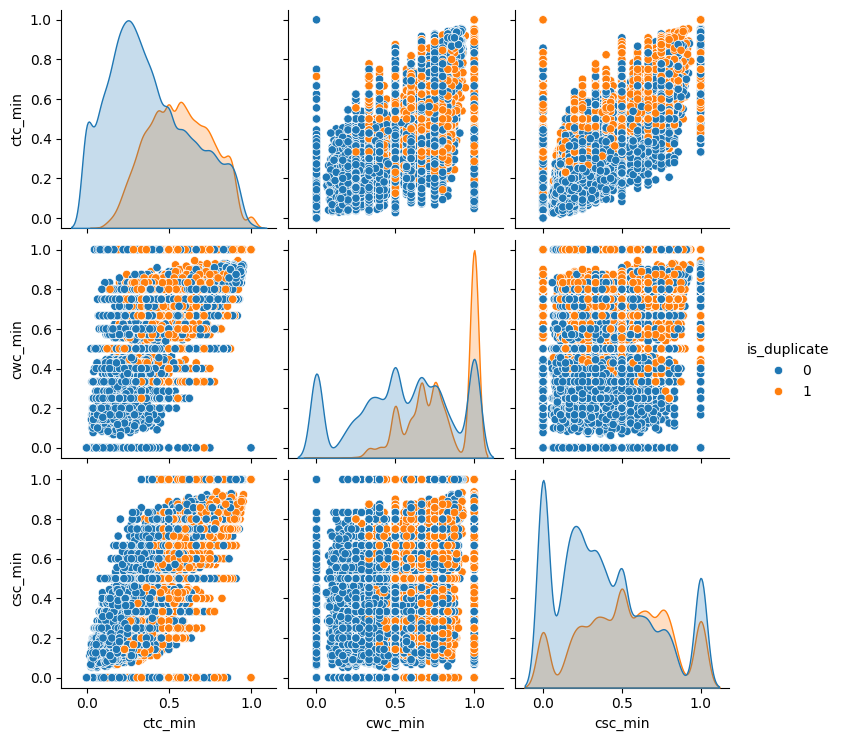

In [71]:
sns.pairplot(df[['ctc_min', 'cwc_min', 'csc_min', 'is_duplicate']],hue='is_duplicate')

In [81]:
df['question1'].iloc[1]

'i am poor but i want to invest what should i do'

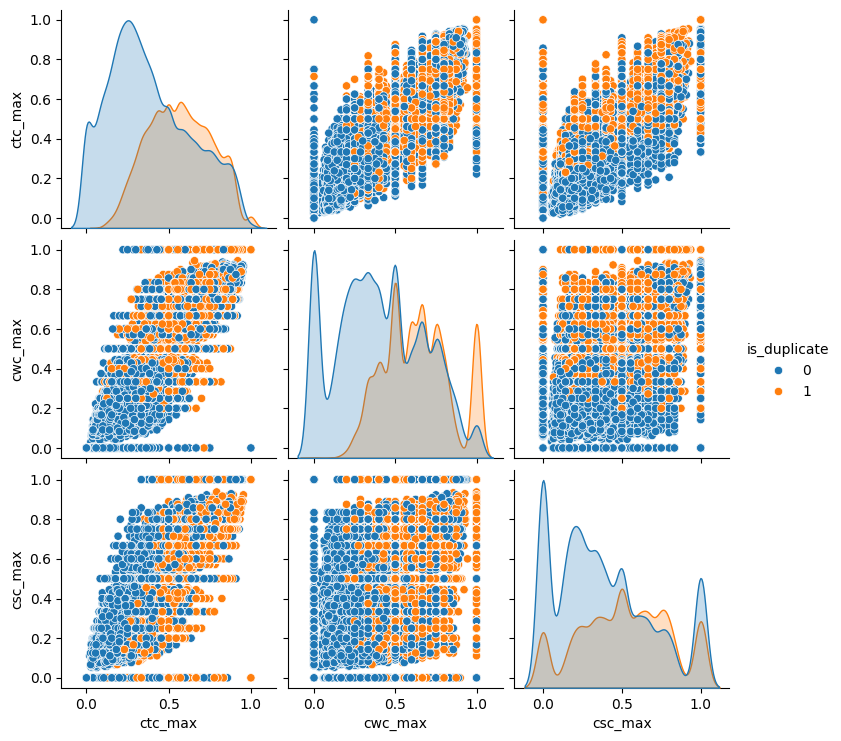

In [74]:
sns.pairplot(df[['ctc_max', 'cwc_max', 'csc_max', 'is_duplicate']],hue='is_duplicate')

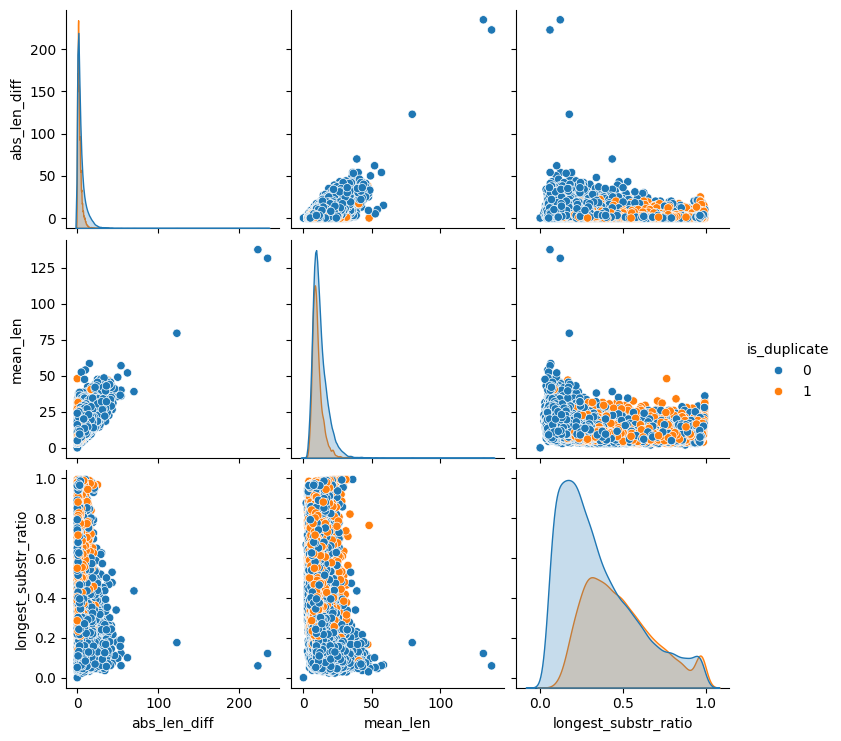

In [75]:
sns.pairplot(df[['abs_len_diff','mean_len','longest_substr_ratio','is_duplicate']],hue='is_duplicate')

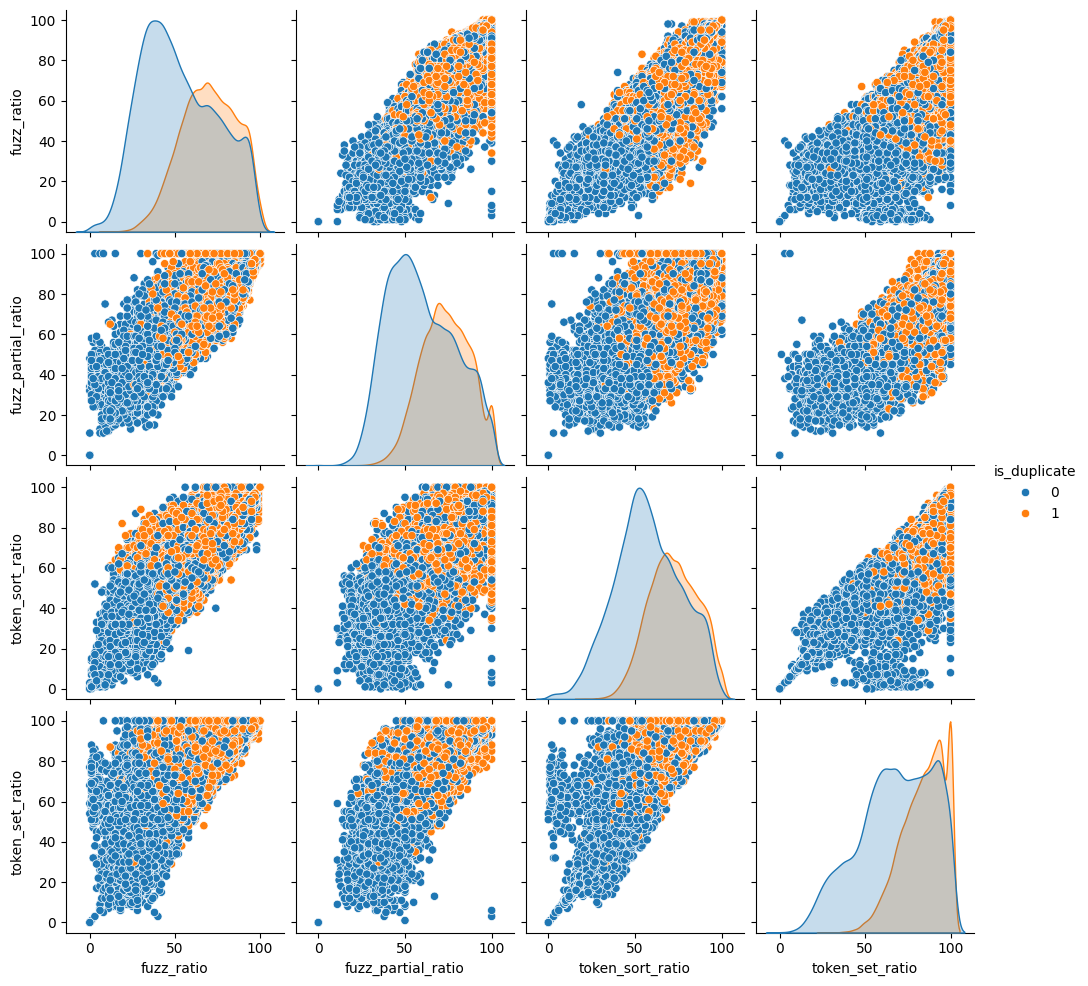

In [45]:
sns.pairplot(df[['fuzz_ratio','fuzz_partial_ratio','token_sort_ratio','token_set_ratio','is_duplicate']],hue='is_duplicate')

In [37]:
#removing stopwords from questions before applying Bag Of Words:
def remove_stop_words(question):
  words = word_tokenize(question)
  stop_words = set(stopwords.words('english'))
  filtered_words = [word for word in words if word.lower() not in stop_words]
  return ' '.join(filtered_words)


df['question1'] = df['question1'].apply(remove_stop_words)
df['question2'] = df['question2'].apply(remove_stop_words)

In [38]:
df.head()

,id,qid1,qid2,question1,question2,is_duplicate,q1_len,q2_len,q1_num_words,q2_num_words,...,ctc_max,first_word_eq,last_word_eq,abs_len_diff,mean_len,longest_substr_ratio,fuzz_ratio,fuzz_partial_ratio,token_sort_ratio,token_set_ratio
316148,316148,441138,441139,peopl natur mean spirit,peopl natur mean,1,40,31,6,5,...,0.833319,0,1,1,5.5,0.961538,88,100,88,100
44799,44799,80366,80367,angular momentum conserv,angular momentum conserv dure elast collis,0,34,55,5,7,...,0.571420,0,0,2,6.0,0.843750,71,87,74,93
315320,315320,46241,160824,one live simpl fulfil life,best way live good simpl life,1,46,51,9,11,...,0.363633,1,0,2,10.0,0.170732,45,57,50,64
142973,142973,1206,226626,whi doe saturn benefit hou sit slowli,whi use drano dishwash drain slowli,0,50,68,10,12,...,0.357140,1,1,4,12.0,0.195652,57,53,50,57
23804,23804,6466,44556,salari ia ip offic,class requir becom ia ip offic,0,51,53,10,10,...,0.399996,1,0,0,10.0,0.142857,52,49,55,62


In [40]:
cv = CountVectorizer(max_features=3000)
ques_df = df[['question1','question2']]
questions = list(ques_df['question1'])+list(ques_df['question2'])
q1_arrf,q2_arrf = np.vsplit(cv.fit_transform(questions).toarray(),2)

In [41]:
temp1 = pd.DataFrame(q1_arrf,index=ques_df.index)
temp2 = pd.DataFrame(q2_arrf,index=ques_df.index)
temp_dff = pd.concat([temp1,temp2],axis=1)
temp_dff.shape

(50000, 6000)

In [42]:
temp_dff.head()

,0,1,2,3,4,5,6,7,8,9,...,2990,2991,2992,2993,2994,2995,2996,2997,2998,2999
316148,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
44799,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
315320,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
142973,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
23804,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [43]:
df.drop(columns=['id','qid1','qid2','question1','question2'],inplace=True)

In [27]:
df.head()

,is_duplicate,q1_len,q2_len,q1_num_words,q2_num_words,common_words,total_words,word_share,cwc_min,cwc_max,...,ctc_max,first_word_eq,last_word_eq,abs_len_diff,mean_len,longest_substr_ratio,fuzz_ratio,fuzz_partial_ratio,token_sort_ratio,token_set_ratio
333895,0,83,93,20,23,7,35,0.20,0.666656,0.571420,...,0.347825,0.0,1.0,3.0,21.5,0.135802,50,54,44,68
238822,0,21,16,5,3,1,8,0.12,0.999900,0.499975,...,0.399992,0.0,1.0,2.0,4.0,0.400000,71,79,76,83
133499,1,72,66,11,11,8,22,0.36,0.999986,0.874989,...,0.818174,1.0,0.0,0.0,11.0,0.450000,89,88,89,91
31237,1,64,207,11,35,6,41,0.15,0.666656,0.307690,...,0.171428,0.0,0.0,24.0,23.0,0.363636,35,59,37,71
374757,0,80,94,16,19,7,34,0.21,0.374995,0.333330,...,0.421050,0.0,0.0,2.0,18.0,0.087500,25,27,46,62


In [44]:
final_df = pd.concat([df,temp_dff],axis=1)
final_df.head()

,is_duplicate,q1_len,q2_len,q1_num_words,q2_num_words,common_words,total_words,word_share,cwc_min,cwc_max,...,2990,2991,2992,2993,2994,2995,2996,2997,2998,2999
316148,1,40,31,6,5,4,11,0.36,0.999967,0.749981,...,0,0,0,0,0,0,0,0,0,0
44799,0,34,55,5,7,3,12,0.25,0.999967,0.499992,...,0,0,0,0,0,0,0,0,0,0
315320,1,46,51,9,11,4,20,0.20,0.599988,0.499992,...,0,0,0,0,0,0,0,0,0,0
142973,0,50,68,10,12,4,22,0.18,0.333328,0.285710,...,0,0,0,0,0,0,0,0,0,0
23804,0,51,53,10,10,2,20,0.10,0.749981,0.499992,...,0,0,0,0,0,0,0,0,0,0


In [45]:
X_train,X_test,y_train,y_test=train_test_split(final_df.iloc[:,1:].values,final_df.iloc[:,0].values,test_size=0.3,random_state=42)

In [46]:
print(X_train.shape,y_train.shape)

(35000, 6022) (35000,)


MODEL BUILDING

In [47]:
rf_advnc = RandomForestClassifier()
rf_advnc.fit(X_train,y_train)

RandomForestClassifier()

In [48]:
y_pred = rf_advnc.predict(X_test)
print('accuracy score: ',accuracy_score(y_test,y_pred))
print(confusion_matrix(y_test,y_pred))

accuracy score:  0.7927333333333333
[[8024 1398]
 [1711 3867]]


In [49]:
def test_common_words(q1,q2):
    w1 = set(map(lambda word: word.lower().strip(), q1.split(" ")))
    w2 = set(map(lambda word: word.lower().strip(), q2.split(" ")))
    return len(w1 & w2)

In [50]:
def test_total_words(q1,q2):
    w1 = set(map(lambda word: word.lower().strip(), q1.split(" ")))
    w2 = set(map(lambda word: word.lower().strip(), q2.split(" ")))
    return (len(w1) + len(w2))

In [51]:
def test_fetch_token_features(q1,q2):

    SAFE_DIV = 0.0001

    STOP_WORDS = stopwords.words("english")

    token_features = [0.0]*8

    # Converting the Sentence into Tokens:
    q1_tokens = q1.split()
    q2_tokens = q2.split()

    if len(q1_tokens) == 0 or len(q2_tokens) == 0:
        return token_features

    # Get the non-stopwords in Questions
    q1_words = set([word for word in q1_tokens if word not in STOP_WORDS])
    q2_words = set([word for word in q2_tokens if word not in STOP_WORDS])

    #Get the stopwords in Questions
    q1_stops = set([word for word in q1_tokens if word in STOP_WORDS])
    q2_stops = set([word for word in q2_tokens if word in STOP_WORDS])

    # Get the common non-stopwords from Question pair
    common_word_count = len(q1_words.intersection(q2_words))

    # Get the common stopwords from Question pair
    common_stop_count = len(q1_stops.intersection(q2_stops))

    # Get the common Tokens from Question pair
    common_token_count = len(set(q1_tokens).intersection(set(q2_tokens)))


    token_features[0] = common_word_count / (min(len(q1_words), len(q2_words)) + SAFE_DIV)
    token_features[1] = common_word_count / (max(len(q1_words), len(q2_words)) + SAFE_DIV)
    token_features[2] = common_stop_count / (min(len(q1_stops), len(q2_stops)) + SAFE_DIV)
    token_features[3] = common_stop_count / (max(len(q1_stops), len(q2_stops)) + SAFE_DIV)
    token_features[4] = common_token_count / (min(len(q1_tokens), len(q2_tokens)) + SAFE_DIV)
    token_features[5] = common_token_count / (max(len(q1_tokens), len(q2_tokens)) + SAFE_DIV)

    # Last word of both question is same or not
    token_features[6] = int(q1_tokens[-1] == q2_tokens[-1])

    # First word of both question is same or not
    token_features[7] = int(q1_tokens[0] == q2_tokens[0])

    return token_features

In [62]:
q1 = 'where is the capital of pakistan'
q2 = 'where is my home ?'
test_fetch_token_features(q1,q2)

[0.0,
 0.0,
 0.6666444451851604,
 0.49998750031249223,
 0.3999920001599968,
 0.3333277778703688,
 0,
 1]

In [52]:
def test_fetch_length_features(q1,q2):

    length_features = [0.0]*3

    # Converting the Sentence into Tokens:
    q1_tokens = q1.split()
    q2_tokens = q2.split()

    if len(q1_tokens) == 0 or len(q2_tokens) == 0:
        return length_features

    # Absolute length features
    length_features[0] = abs(len(q1_tokens) - len(q2_tokens))

    #Average Token Length of both Questions
    length_features[1] = (len(q1_tokens) + len(q2_tokens))/2

    strs = list(distance.lcsubstrings(q1, q2))
    length_features[2] = len(strs[0]) / (min(len(q1), len(q2)) + 1)

    return length_features

In [53]:
def test_fetch_fuzzy_features(q1,q2):

    fuzzy_features = [0.0]*4

    # fuzz_ratio
    fuzzy_features[0] = fuzz.QRatio(q1, q2)

    # fuzz_partial_ratio
    fuzzy_features[1] = fuzz.partial_ratio(q1, q2)

    # token_sort_ratio
    fuzzy_features[2] = fuzz.token_sort_ratio(q1, q2)

    # token_set_ratio
    fuzzy_features[3] = fuzz.token_set_ratio(q1, q2)

    return fuzzy_features

In [54]:
#removing stopwords from questions before applying Bag Of Words:
def remove_stop_words(q1, q2):
    # Tokenize both questions
    q1_tokens = word_tokenize(q1)
    q2_tokens = word_tokenize(q2)

    # Define stop words
    stop_words = set(stopwords.words('english'))

    # Filter out stop words from both questions
    q1_filtered = [word for word in q1_tokens if word.lower() not in stop_words]
    q2_filtered = [word for word in q2_tokens if word.lower() not in stop_words]

    # Return filtered questions as strings
    return ' '.join(q1_filtered), ' '.join(q2_filtered)


In [55]:
def query_point_creator(q1,q2):

    input_query = []

    # preprocess
    q1 = preprocessor(q1)
    q2 = preprocessor(q2)

    # fetch basic features
    input_query.append(len(q1))
    input_query.append(len(q2))

    input_query.append(len(q1.split(" ")))
    input_query.append(len(q2.split(" ")))

    input_query.append(test_common_words(q1,q2))
    input_query.append(test_total_words(q1,q2))
    input_query.append(round(test_common_words(q1,q2)/test_total_words(q1,q2),2))

    # fetch token features
    token_features = test_fetch_token_features(q1,q2)
    input_query.extend(token_features)

    # fetch length based features
    length_features = test_fetch_length_features(q1,q2)
    input_query.extend(length_features)

    # fetch fuzzy features
    fuzzy_features = test_fetch_fuzzy_features(q1,q2)
    input_query.extend(fuzzy_features)

    # Remove stop words from preprocessed questions for BoW and other features
    q1, q2 = remove_stop_words(q1, q2)

    # bow feature for q1
    q1_bow = cv.transform([q1]).toarray()

    # bow feature for q2
    q2_bow = cv.transform([q2]).toarray()



    return np.hstack((np.array(input_query).reshape(1,22),q1_bow,q2_bow))

In [56]:
q1 = 'Where is the capital of India?'
q2 = 'What is the current capital of Pakistan?'
q3 = 'Which city serves as the capital of India?'
q4 = 'What is the business capital of India?'

In [57]:
rf_advnc.predict(query_point_creator(q1,q2))

array([0])

In [58]:
import pickle

pickle.dump(rf_advnc,open('model.pkl','wb'))
pickle.dump(cv,open('cv.pkl','wb'))

In [60]:
from joblib import dump, load

dump(rf_advnc, 'model.joblib')
dump(cv, 'cv.joblib')

['cv.joblib']